In [1]:
%matplotlib inline
import pandas as pd
import numpy as np


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns



import scipy.stats as stats
from sklearn import metrics
from sklearn import preprocessing
from sklearn import  linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

## 2. Import the dataset

In [2]:
df_bike_hour = pd.read_csv("data/hour.csv")

## 3. Exploratory Data Analysis & Preprocessing

 -  Let us have a look at number of rows and columns in the imported dataset

In [3]:
print(f"Shape of the imported dataset: {df_bike_hour.shape}")

Shape of the imported dataset: (17379, 17)


The dataset has more than 17000 records and 17 attributes.
 -  Next we check out a few observations from the data

In [4]:
df_bike_hour.head(n = 3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


 - Attribute names (column headers) need to be standardised for better readability and understanding

In [5]:
df_bike_hour.rename(columns = {
    'instant': 'id',
    'dteday': 'date',
    'yr':'year',
    'mnth':'month',
    'hr':'hour',
    'holiday':'is_holiday',
    'workingday': 'is_workingday',
    'weathersit': 'weather_condition',
    'cnt':'total_count'    
}, inplace=True)

 - Dimensions like weekday, year, month, etc. look like integers but should be categorical; let us inspect what are the  implicitly inferred data types for different such dimensions

In [6]:
df_bike_hour.dtypes

id                     int64
date                  object
season                 int64
year                   int64
month                  int64
hour                   int64
is_holiday             int64
weekday                int64
is_workingday          int64
weather_condition      int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
total_count            int64
dtype: object

 - Indeed, these attributes are taken as integers and need to be converted to categorical values. Also, "date" is supposed to be a datetime value as per the data documentation

In [7]:
#Convert to date
df_bike_hour['date'] = pd.to_datetime(df_bike_hour.date)
#Convert some of the integer features to categorical variables
df_bike_hour['year'] = df_bike_hour.season.astype('category')
df_bike_hour['month'] = df_bike_hour.month.astype('category')
df_bike_hour['hour'] = df_bike_hour.hour.astype('category')
df_bike_hour['weekday'] = df_bike_hour.weekday.astype('category')
df_bike_hour['is_holiday'] = df_bike_hour.is_holiday.astype('category')
df_bike_hour['is_workingday'] = df_bike_hour.is_workingday.astype('category')
df_bike_hour['weather_condition'] = df_bike_hour.weather_condition.astype('category')

 - <strong>Visualising trends in data</strong>   
 1) We inspect how does <font color="blue">hourly</font> bike riding varies with different seasons

[Text(0.5,1,'fig 1. Seasonwise hourly trends in bike usage')]

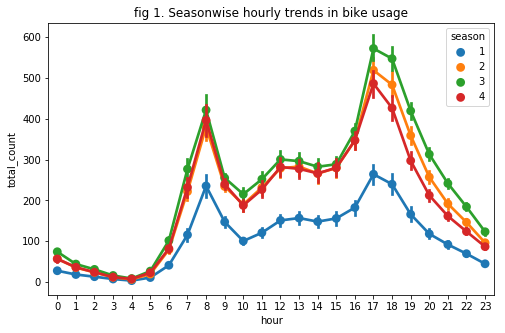

In [8]:

fig, ax = plt.subplots()
fig.set_size_inches(8,5)
sns.pointplot(data=df_bike_hour[['hour', 'total_count', 'season']], 
              x='hour', y='total_count', hue='season', ax=ax)
ax.set(title = 'fig 1. Seasonwise hourly trends in bike usage')


Bike riding trends seem to be similar accross all the seasons. Demand for bikes is likely to surge in the morning 7 - 9 am and again in the evening between 5 - 7 pm which represent the typical start/ end of day at school, university or work. Also, demand seems to be at the lowest during spring season and highest during fall across all hours of the day.   

2) Now, we explore how does <font color="blue">weekly</font> bike riding varies with different seasons

[Text(0.5,1,'fig 2. Hourly trends in bike usage on different weekdays')]

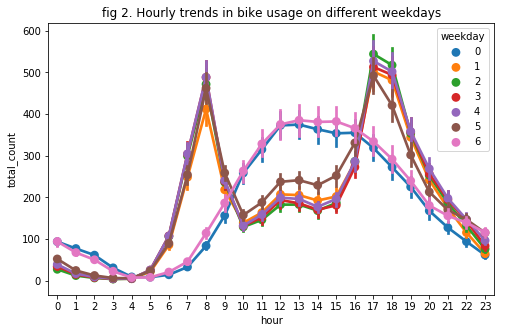

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(8,5)
sns.pointplot(data=df_bike_hour[['hour', 'total_count', 'weekday']], 
              x='hour', y='total_count', hue='weekday', ax=ax)
ax.set(title = 'fig 2. Hourly trends in bike usage on different weekdays')

We notice that bikes are in high demand during afternoons on weekends, while on weekdays, the ridership peaks only during morning or evening

3) The above plots gave a good picture about bike ridership on weekly and hourly basis. Next, we aggregate the numbers to view <font color="blue">monthly</font> trends, if any.

[Text(0.5,1,'fig 3. Monthly aggregation of bike ride counts')]

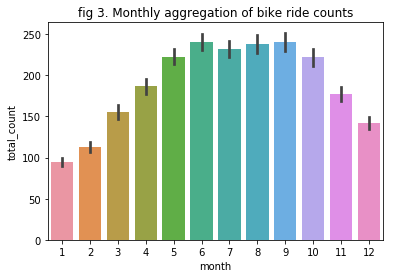

In [10]:
fig, ax = plt.subplots()
sns.barplot(data = df_bike_hour[['month', 'total_count']],
           x = "month", y = "total_count")
ax.set(title = "fig 3. Monthly aggregation of bike ride counts")

It looks like bike ridership picks up during summer months of May, June and continues till onset of fall, after which it gradually declines during winter   
    
4) We will examine this <font color="blue">seasonal</font> variance in bike ride counts below.

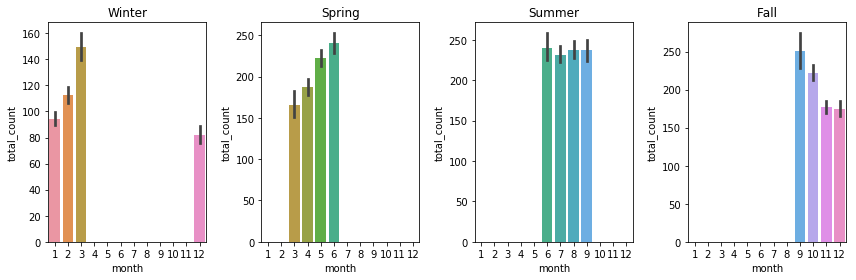

In [11]:
plt.close('all')
fig = plt.figure()

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(12, 4)) 
gs = gridspec.GridSpec(1, 4)

seasons = ["Winter", "Spring", "Summer", "Fall"]
for i, season in enumerate(seasons):
    p = i + 1
    df = df_bike_hour[df_bike_hour['season'] == p][['month', 'total_count']]
    ax = fig.add_subplot(gs[i])
    sns.barplot(data = df,
       x = "month", y = "total_count").set_title(season)

gs.tight_layout(fig, h_pad=2)


We notice that demand for bikes is consistently high during summer months or during build up to summer months. As expected, few people like to ride bikes during chilly winters in Washington!   

<strong><font size=4 color="blue">Outlier detection</font></strong>   

We would like to ensure that we have outliers as much less in number as possible, before fitting the model. We check for outliers in numerical variables like temperature, humidity, casual, windspeed and total count of bikes.

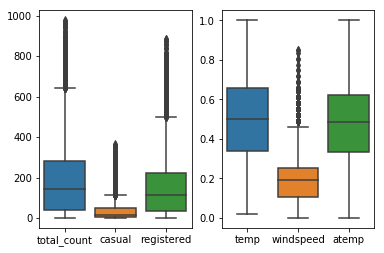

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.boxplot(data=df_bike_hour[['total_count', 'casual', 'registered']], ax=ax1)
sns.boxplot(data=df_bike_hour[['temp', 'windspeed', 'atemp']], ax=ax2)

It is seen that total count, registerd and casual number of bikes all have quite a few number of outlier values that are higher than most others. However, among temperature, feeling temperature and windspeed, only windspeed seems to have some outlier values

<strong><font size=4 color="blue">Correlation analysis</font></strong> 

Since, we plan to fit regression model with the dataset, it would be beneficial to explore the correlation between different variables. This would help identifying multicollinearity in variables, if exists.

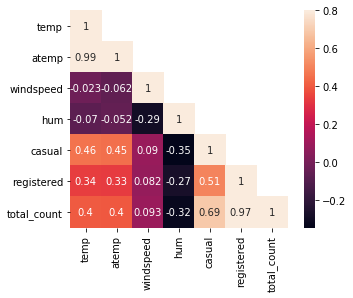

In [13]:
correlation_matrix = df_bike_hour[["temp", "atemp", "windspeed", "hum", "casual", "registered", "total_count"]].corr()
mask = np.array(correlation_matrix)
mask[np.tril_indices_from(mask)] = False
sns.heatmap(correlation_matrix, mask=mask,
vmax=.8, square=True,annot=True)

 - There is an obvious strong correlation between total number of riders and registered/ casual riders
 - Similarly, there is naturally a strong correlation between 2 temperature values
 - Moderately strong positive correlation is observed between temperature and bike ridership
 - Also, bike count seems to be somewhat negatively correlated to humidity

## 4. Prepare train-test dataset for training model    
As we go for training the model, we first split the dataset into training and testing sets

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
# Use 1/3rd of data for testing and 2/3rds for training the model
X_train, X_test, y_train, y_test = train_test_split(df_bike_hour.iloc[:,0:-3],
                                                   df_bike_hour.iloc[:,-1],
                                                   test_size = 0.33,
                                                   random_state = 1)
X_train.reset_index(inplace=True)
X_test.reset_index(inplace=True)
y_train = y_train.reset_index()
y_test = y_test.reset_index()

In [16]:
from helper_methods import label_one_hot_encode
#Iterate through all categorical features and one hot encode them
categorical_features = ['season','is_holiday','weather_condition','is_workingday']
encoded_attributes = []
#Encode all required categorical columns
for attr in categorical_features:
    transformed = label_one_hot_encode(X_train, attr)
    encoded_attributes.append({'label_encoder':transformed[0],
                                'ohe_encoder':transformed[1],
                                'df_feature':transformed[2],
                                'attribute_name':attr})
    
#Slice all numeric values for prediction
df_features_numeric = [X_train.loc[:,['temp','hum','windspeed','hour','weekday','month','year']]]
#Apend one encoded columns
df_features_numeric.extend([ef['df_feature'] for ef in encoded_attributes])
#Concatenate other numeric features with one hot encoded features
df_all_features = pd.concat(df_features_numeric, axis = 1)
#Observe first few rows of final training set
df_all_features.head(3)

,temp,hum,windspeed,hour,weekday,month,year,season_1,season_2,season_3,season_4,is_holiday_0,is_holiday_1,weather_condition_1,weather_condition_2,weather_condition_3,weather_condition_4,is_workingday_0,is_workingday_1
0,0.32,0.39,0.1940,20,5,11,4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.60,0.88,0.0000,5,0,7,3,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.50,0.77,0.1642,4,1,9,3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## 5. Train the regression model   

In [18]:
X = df_all_features
y = y_train.total_count.values.reshape(-1, 1)
linear_regression_model = linear_model.LinearRegression()

Text(0,0.5,'Residual')

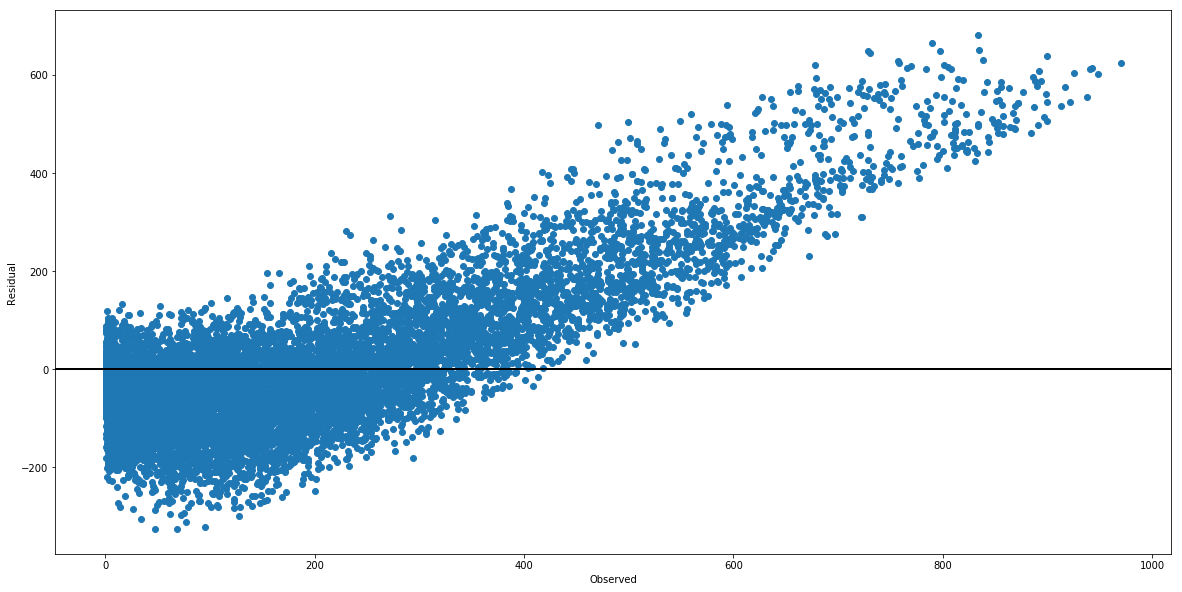

In [25]:
predicted = cross_val_predict(linear_regression_model, X, y, cv=10)
fig, ax = plt.subplots(figsize=(20, 10))
#fig, ax = plt.subplots()
ax.scatter(y, y-predicted)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')

#plt.show()

In [27]:
r2_scores = cross_val_score(linear_regression_model, X, y, cv=10)
mse_scores = cross_val_score(linear_regression_model, X, y, cv=10,scoring='neg_mean_squared_error')

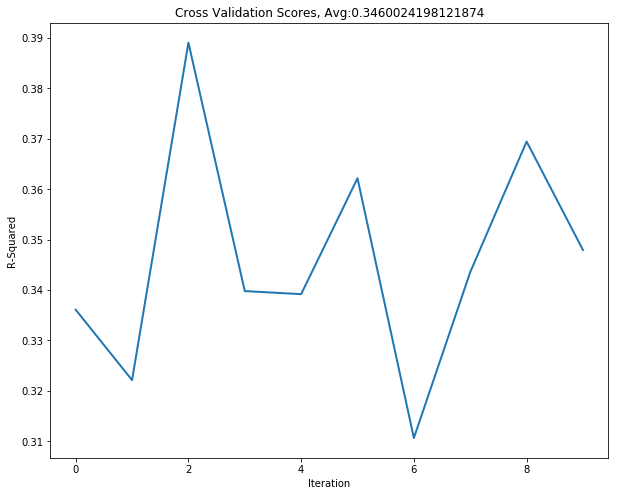

In [30]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot([i for i in range(len(r2_scores))],r2_scores,lw=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('R-Squared')
ax.title.set_text("Cross Validation Scores, Avg:{}".format(np.average(r2_scores)))
plt.show()

In [32]:
print("R-squared value: {}".format(r2_scores))
print("MSE value: {}".format(mse_scores))

R-squared value: [ 0.33609566  0.32212445  0.38907366  0.33979094  0.33917945  0.36217083
  0.31063486  0.34355234  0.36946062  0.3479414 ]
MSE value: [-23480.36550192 -22988.60984514 -19045.97253972 -22307.98899689
 -19749.32909302 -20453.24222014 -21289.2080334  -21404.97020754
 -19057.16551655 -21058.04447322]
